## Getting the datasets

In [43]:
import pickle

training_file = "data/train.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [44]:
import numpy as np

n_train = X_train.shape[0]
n_test = X_test.shape[0]
image_shape = X_train[0].shape
n_classes =  len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [45]:
# np.unique(y_train)
y_train

array([41, 41, 41, ..., 25, 25, 25], dtype=uint8)

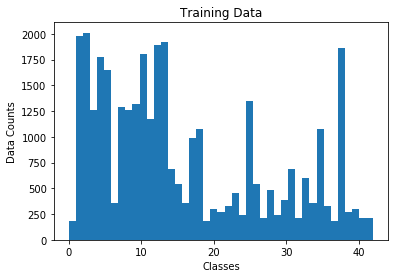

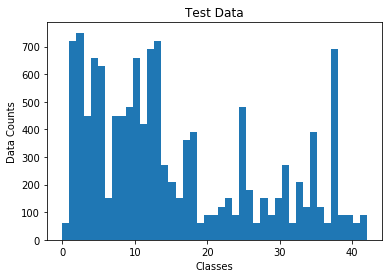

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(y_train, bins = n_classes)
plt.xlabel('Classes')
plt.ylabel('Data Counts')
plt.title('Training Data')
plt.show();

plt.hist(y_test, bins = n_classes)
plt.xlabel('Classes')
plt.ylabel('Data Counts')
plt.title('Test Data')
plt.show();

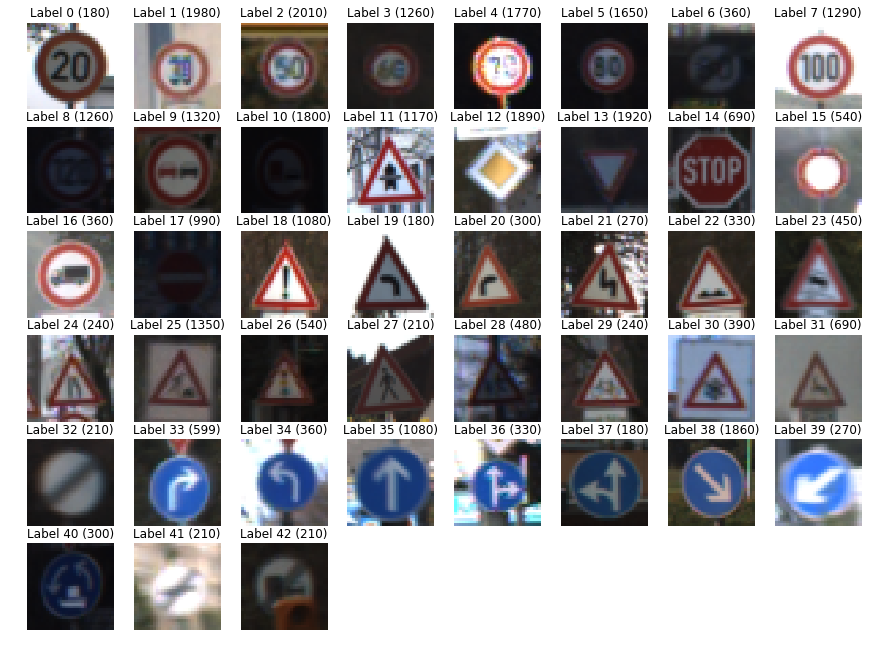

In [47]:
import random
def display_images_and_labels(images, labels):
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        cnt = sum(labels == label)
        img_ind = random.choice(np.where(labels == label)[0])
        image = images[img_ind]
        plt.subplot(8, 8, i)
        plt.axis('off')
        plt.title('Label %d (%d)' % (label, cnt))
        i += 1
        plt.imshow(image)
    plt.show()

display_images_and_labels(X_train, y_train)

<Figure size 1080x1080 with 0 Axes>

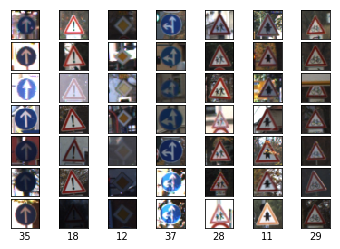

In [48]:
def plot_images(image, label, label_number, image_number):
    sample_classes = random.sample(range(min(y_train), max(y_train) + 1), label_number)
    plt.figure(figsize=(15, 15))
    fig, axes = plt.subplots(label_number, image_number)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for i, ax in enumerate(axes.flat):
        cls = sample_classes[i%label_number]
        img_ind = random.choice(np.where(y_train == cls)[0])
        ax.imshow(image[img_ind]);
        ax.set_xlabel(str(cls))
        ax.set_xticks([])
        ax.set_yticks([])

plot_images(X_train, y_train, 7, 7)

## Preprocessing Data

In [49]:
from sklearn.preprocessing import LabelBinarizer

def normalize_img(img):
    x_min = 0
    x_max = 255
    a = -1.0
    b = 1.0
    return a + (img - x_min) * (b - a) / (x_max - x_min)

X_train = normalize_img(X_train)  
X_test = normalize_img(X_test)


encoder = LabelBinarizer()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)


y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

## Test Validation Split

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2)

print("trainning data size: %d, validation data size: %d" %(X_train.shape[0], X_valid.shape[0]))

trainning data size: 27839, validation data size: 6960


## Convolutional Neural Network Model

In [8]:
import tensorflow as tf

# Input image size
image_size = X_train[0].shape[0]
num_channels = X_train[0].shape[2]

# Filter size
patch_size = 5
depth1 = 32
depth2 = 64
num_hidden = 1024

graph = tf.Graph()
with graph.as_default():
    features = tf.placeholder(tf.float32, [None, image_size, image_size, num_channels])
    labels = tf.placeholder(tf.float32, [None, n_classes])
    keep_prob = tf.placeholder(tf.float32)
    betha = tf.placeholder(tf.float32)
    learning_rate = tf.placeholder(tf.float32)
    
    
    weights =  {
        'layer1': tf.Variable(tf.truncated_normal(shape = [patch_size, patch_size, num_channels, depth1], 
                                                  stddev = 0.1)),
        'layer2': tf.Variable(tf.truncated_normal(shape = [patch_size, patch_size, depth1, depth2], 
                                                  stddev = 0.1)),
        'layer3': tf.Variable(tf.truncated_normal(shape = [image_size // 4 * image_size // 4 * depth2, num_hidden], 
                                                  stddev = 0.1)),
        'layer4': tf.Variable(tf.truncated_normal(shape = [num_hidden, n_classes], stddev = 0.1))
    }
    
    biases = {
        'layer1': tf.Variable(tf.zeros([depth1])),
        'layer2': tf.Variable(tf.zeros([depth2])),
        'layer3': tf.Variable(tf.zeros([num_hidden])),
        'layer4': tf.Variable(tf.zeros([n_classes]))
    }
    
    # Layer 1, output size: 16 x 16 x 32
    conv = tf.nn.conv2d(features, weights['layer1'], [1, 1, 1, 1], padding = 'SAME')
    hidden = tf.nn.relu(conv + biases['layer1'])
    pool = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

    # Layer 2, output size: 8 x 8 x 64
    conv = tf.nn.conv2d(pool, weights['layer2'], [1, 1, 1, 1], padding = 'SAME')
    hidden = tf.nn.relu(conv + biases['layer2'])
    pool = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    
    # Layer 3, output size: 1 x 1024
    shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, shape = [-1, shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, weights['layer3']) + biases['layer3'])
    hidden = tf.nn.dropout(hidden, keep_prob)
    
    # Layer 4, output size: 1 x 43
    logits = tf.matmul(hidden, weights['layer4']) + biases['layer4']

    # Regulation
    regul = betha * (tf.nn.l2_loss(weights['layer1']) + 
                     tf.nn.l2_loss(weights['layer2']) +
                     tf.nn.l2_loss(weights['layer3']) +
                     tf.nn.l2_loss(weights['layer4']) )
    # Optimizaer
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels) + regul)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    # Prediction
    prediction = tf.nn.softmax(logits)
    # Top five result
    top_five = tf.nn.top_k(prediction, 5)
    # Correct prediction
    correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
    # Accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    # Model saver
    saver = tf.train.Saver()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [19]:
epochs = 10

# Batch size
batch_size = 128

# Training data size
train_data_size = X_train.shape[0]

# Feed_dict for validation data
feed_dict_valid = {features: X_valid, labels: y_valid, keep_prob: 1.0}

# Feed_dict for test data
feed_dict_test = {features: X_test, labels: y_test, keep_prob: 1.0}

with tf.Session(graph = graph) as session:
#     tf.initialize_all_variables().run()
    session.run(tf.global_variables_initializer())
    for epoch in range(1, epochs + 1):
        ind = np.arange(0, train_data_size)
        np.random.shuffle(ind)
        X_train_shuffle = X_train[ind]
        y_train_shuffle = y_train[ind]
        for batch_ind in range(0, train_data_size - batch_size, batch_size):
            batch_data = X_train_shuffle[batch_ind : (batch_ind + batch_size), :, :, :]
            batch_labels = y_train_shuffle[batch_ind : (batch_ind + batch_size), :]
            feed_dict_train = { features: batch_data, 
                                labels: batch_labels, 
                                keep_prob: 0.5,
                                betha: 1e-6,
                                learning_rate: 1e-3 }
            _, l, acc = session.run([optimizer, loss, accuracy], feed_dict = feed_dict_train)
        print("epoch: %d\tloss: %f\taccuracy: %f" %(epoch, l, acc))
        valid_acc = accuracy.eval(feed_dict = feed_dict_valid)
        print("validation accuracy:\t%f" %valid_acc)
        if(valid_acc > 0.99 and acc > 0.99):
            break

    save_model = saver.save(session, "./model.ckpt")
    print("Model saved as %s" %save_model)

epoch: 1	loss: 0.704118	accuracy: 0.781250
validation accuracy:	0.903448
epoch: 2	loss: 0.196601	accuracy: 0.945312
validation accuracy:	0.967241
epoch: 3	loss: 0.156169	accuracy: 0.960938
validation accuracy:	0.977155
epoch: 4	loss: 0.134795	accuracy: 0.960938
validation accuracy:	0.983333
epoch: 5	loss: 0.112585	accuracy: 0.984375
validation accuracy:	0.985776
epoch: 6	loss: 0.044040	accuracy: 0.984375
validation accuracy:	0.990086
epoch: 7	loss: 0.034437	accuracy: 1.000000
validation accuracy:	0.990948
Model saved as ./model.ckpt


In [9]:
import numpy as np

# Getting the truth label reference from the provided csv file
truth_label = np.genfromtxt('signnames.csv', 
                            delimiter=',' , 
                            usecols=(1,), 
                            unpack=True,  
                            dtype=str,  
                            skip_header=1)

In [24]:
truth_label


array(['Speed limit (20km/h)', 'Speed limit (30km/h)',
       'Speed limit (50km/h)', 'Speed limit (60km/h)',
       'Speed limit (70km/h)', 'Speed limit (80km/h)',
       'End of speed limit (80km/h)', 'Speed limit (100km/h)',
       'Speed limit (120km/h)', 'No passing',
       'No passing for vechiles over 3.5 metric tons',
       'Right-of-way at the next intersection', 'Priority road', 'Yield',
       'Stop', 'No vechiles', 'Vechiles over 3.5 metric tons prohibited',
       'No entry', 'General caution', 'Dangerous curve to the left',
       'Dangerous curve to the right', 'Double curve', 'Bumpy road',
       'Slippery road', 'Road narrows on the right', 'Road work',
       'Traffic signals', 'Pedestrians', 'Children crossing',
       'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing',
       'End of all speed and passing limits', 'Turn right ahead',
       'Turn left ahead', 'Ahead only', 'Go straight or right',
       'Go straight or left', 'Keep right', 'Keep le

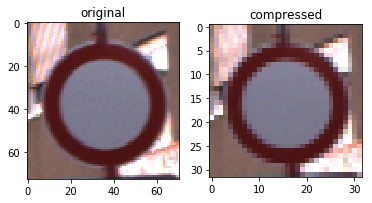

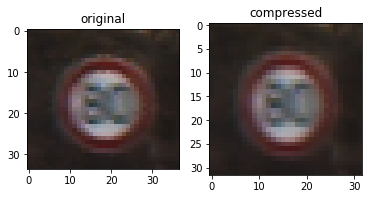

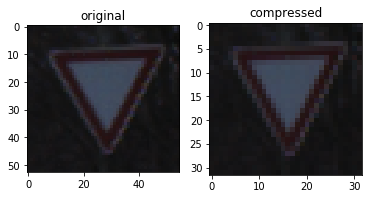

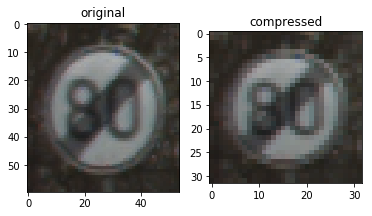

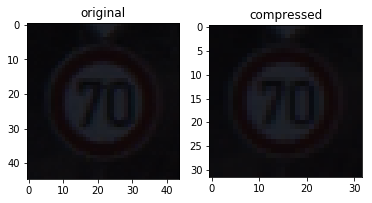

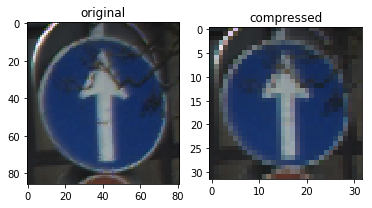

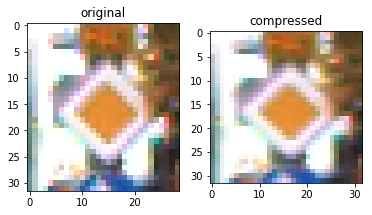

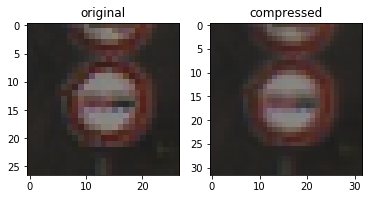

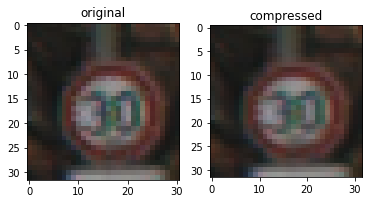

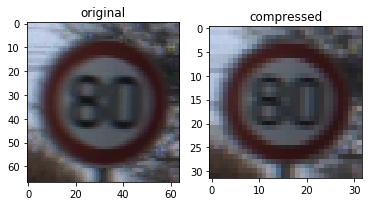

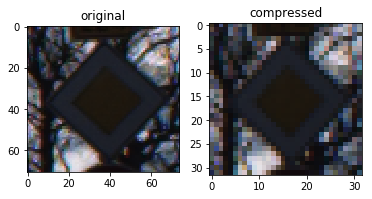

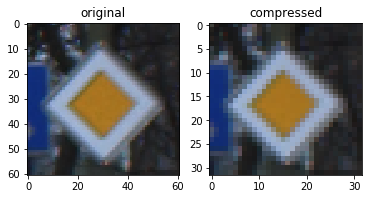

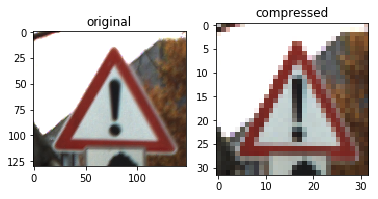

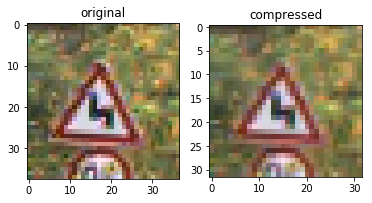

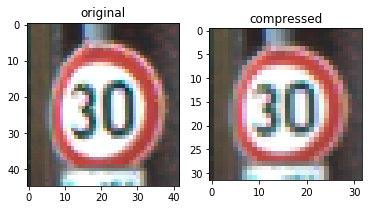

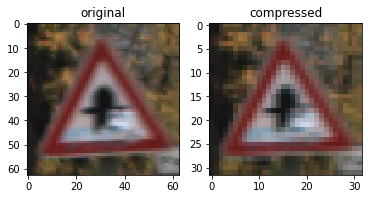

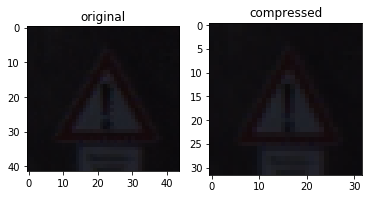

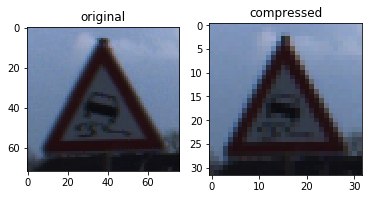

In [25]:
def normalize_img(img):
    x_min = 0
    x_max = 255
    a = -1.0
    b = 1.0
    return a + (img - x_min) * (b - a) / (x_max - x_min)


import matplotlib.image as mpimg
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline


web_images = np.empty(shape = [1, 32, 32, 3], dtype = np.float32)
web_labels = np.empty(shape = [1], dtype = np.int8)

# Image directory
directory = 'Images1/'

# Go through all the files
for file in os.listdir(directory):
    # Skip the garbage file
    if(file == '.DS_Store'):
        continue
    # Read the image
    img = mpimg.imread(os.path.join(directory, file))
    if(img.shape[2] == 4):
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    # Compress the image to 32 by 32
    resize_img = cv2.resize(img, (32, 32))
    # Normalize the image
    norm_resize_img = np.reshape(normalize_img(resize_img),[1, 32, 32, 3])
    # Add the image to the array
    web_images = np.vstack([web_images, norm_resize_img])
    # Get the label number from the file name
    label = np.int8(os.path.splitext(file)[0])
    web_labels = np.vstack([web_labels, label])
    # Plot the original image
    plt.figure()
    plt.subplot(121)
    plt.imshow(img)
    plt.title('original')
    # Plot the compressed image
    plt.subplot(122)
    plt.imshow(resize_img)
    plt.title('compressed')
    plt.show()
    
# Get rid of the first empty row
web_images = web_images[1:, :, :, :]
web_labels = web_labels[1:]

# One-hot encoding of the labels
web_labels_encoded = encoder.transform(web_labels)

In [26]:
web_images.shape

(18, 32, 32, 3)

In [27]:
web_labels.shape

(18, 1)

In [42]:
feed_dict_web = {features: web_images, labels: web_labels_encoded, keep_prob: 1.0}

with tf.Session(graph = graph) as sess:
    # Restore the trained model
    saver.restore(sess, 'model.ckpt')
    # Get the top five result
    acc, top_five_res = sess.run([accuracy, top_five], feed_dict = feed_dict_web)
    # Go through all the images
    for i in range(web_images.shape[0]):
        if int(np.squeeze(web_labels[i])) > 42:
            continue
        print(i)
        print('\n-----------------------------')
        print(np.squeeze(web_labels[i]))
        
        print('image %d ' %(i+1))
        print('\nClassifier top 5:')
        for j in range(5):
            # Get the probability of the result
            prob = top_five_res.values[i][j]*100
            if(prob < 0.1):
                break
            # Get the label of the result
            label = truth_label[top_five_res.indices[i][j]]
            print('%.1f%%\t\t%s' %(prob, label))

INFO:tensorflow:Restoring parameters from model.ckpt
0

-----------------------------
19
image 1 

Classifier top 5:
100.0%		No vechiles
1

-----------------------------
39
image 2 

Classifier top 5:
100.0%		Speed limit (80km/h)
5

-----------------------------
9
image 6 

Classifier top 5:
100.0%		Ahead only
6

-----------------------------
37
image 7 

Classifier top 5:
100.0%		Priority road
7

-----------------------------
15
image 8 

Classifier top 5:
100.0%		No passing
9

-----------------------------
30
image 10 

Classifier top 5:
96.9%		Speed limit (80km/h)
3.1%		Speed limit (50km/h)
11

-----------------------------
36
image 12 

Classifier top 5:
100.0%		Priority road
12

-----------------------------
6
image 13 

Classifier top 5:
100.0%		General caution
13

-----------------------------
16
image 14 

Classifier top 5:
79.1%		Double curve
20.9%		Wild animals crossing
14

-----------------------------
1
image 15 

Classifier top 5:
100.0%		Speed limit (30km/h)
15

---------